## Load needed things

### Import packages

In [70]:
import numpy as np
import nltk
import pandas as pd
import xml.etree.ElementTree as ET
from collections import namedtuple
from os import listdir
from os.path import isfile, join
import re
import string
from typing import Callable, List
import unidecode
from spellchecker import SpellChecker
import urllib.request
import json
from tqdm import tqdm
import spacy
import ftfy
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from polyglot.text import Text

%matplotlib inline
nlp = spacy.load('es')
tqdm.pandas()

### Define named tuple

In [2]:
tweet = namedtuple('Tweet', ['tweetid', 'content', 'polarity'])

### Define stopwords

In [3]:
stopWords = set(nltk.corpus.stopwords.words('spanish'))

## Preprocessing

### Read data

In [4]:
def read_data(file: str) -> pd.DataFrame:
    """Read data from given file and return it as a dataframe."""
    tweets: List = []
    with open(file, 'r') as f:
        tree = ET.parse(file)
        root = tree.getroot()
        for child in root:
            tweets.append(tweet(child[0].text, child[2].text, child[5][0][0].text))
    return pd.DataFrame(tweets)

def read_folder(folder: str) -> pd.DataFrame:
    """
    Read data from given folder, combines the training and dev set
    and return them combined as a dataframe.
    """
    dataframes = []
    files = [f for f in listdir(folder) if isfile(join(folder, f))]
    for file in files:
        if 'xml' in file:
            dataframes.append(read_data(folder + file))
    return pd.concat(dataframes)

### String manipulation

Don't need to care for emoticons, because there are less than 10.

In [43]:
def remove_mention(tweet: str) -> str:
    return re.sub(r'@[A-Za-z0-9]+', '', tweet) 

def lower_case(tweet: str) -> str:
    """Turn a tweet to lower case."""
    return tweet.lower()

def remove_question_mark(tweet: str) -> str:
    """Remove spanish question mark from a tweet."""
    return tweet.replace('¿', '')

def remove_punctuation(tweet: str) -> str:
    """Remove punctuation from a tweet."""
    return tweet.translate(str.maketrans('', '', string.punctuation))

def remove_whitespace(tweet: str) -> str:
    return tweet.strip()

def check_int(s):
    if s[0] in ('-', '+'):
        return s[1:].isdigit()
    return s.isdigit()

def remove_numbers(tweet: str) -> str:
    """Remove numbers from tweet."""
    tokenized = nltk.word_tokenize(tweet)
    return ' '.join([word for word in tokenized if not check_int(word)])

def fix_encoding(tweet: str) -> str:
    return ftfy.fix_encoding(tweet)

def fix_repeated_letters(tweet: str) -> str:
    """Replace repeated characters (3 repetitions or more) with only two characters."""
    return re.sub(r'(.)\1+', r'\1\1', tweet)

def clean_tweet(tweet: str) -> str:
    """Run a tweet through cleaning pipeline."""
    # List of function
    functions: List[Callable] = [
                 remove_mention,
                 lower_case,
                 remove_question_mark,
                 remove_punctuation,
                 remove_whitespace,
                 remove_numbers,
                 fix_encoding,
                 fix_repeated_letters
                 ]
    for f in functions:
        tweet = f(tweet)
        
    return tweet

### Spelling
Preprocessing that should be done after spell correction.

In [6]:
spell = SpellChecker(language='es')

def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def fix_spelling(tweet: str) -> str:
    """Fix spelling error in tweets."""
    tokenized = nltk.word_tokenize(tweet)
    misspelled = spell.unknown(tokenized)
    for i in range(len(tokenized)):
        if tokenized[i] in misspelled:
            if is_ascii(tokenized[i]):
                contents = urllib.request.urlopen(f"http://api.urbandictionary.com/v0/define?term={tokenized[i]}").read()
                contents = json.loads(contents)['list']
            
                # Check if the word is spelling error or is in urban dictionary
                if contents and contents[0]['word'].lower().strip() == tokenized[i]:
                    continue
            tokenized[i] = spell.correction(tokenized[i])
    return ' '.join(tokenized)

def remove_stopwords(tweet: str) -> str:
    """Remove stopwords from tweet."""
    tokenized = nltk.word_tokenize(tweet)
    return ' '.join([word for word in tokenized if word not in stopWords])

def stem_tweet(tweet: str) -> str:
    tweet = nlp(tweet)
    return ' '.join([token.lemma_ for token in tweet])


def clean_tweet2(tweet: str) -> str:
    """Run a tweet through cleaning pipeline."""
    # List of function
    functions: List[Callable] = [
                 remove_stopwords,
                 stem_tweet
                 ]
    for f in functions:
        tweet = f(tweet)
        
    return tweet

### Clean and save

In [7]:
df = read_folder("data/cr/")
df['content'] = df['content'].progress_apply(clean_tweet)
df['content'] = df['content'].progress_apply(fix_spelling)
df['content'] = df['content'].progress_apply(clean_tweet2)
df.to_csv("data/cr/cleaned.csv")

100%|██████████| 1167/1167 [00:08<00:00, 135.10it/s]


## Explore data

### Load data from file

In [58]:
df = pd.read_csv("data/cr/cleaned.csv")

In [9]:
df.head()

,Unnamed: 0,tweetid,content,polarity
0,0,768225400254111744,totalmente puntual,NONE
1,1,770077064833671168,hola sandrita habia desear feliz dia madre tar...,P
2,2,771207534342320128,si andar hacer mejor quedar calladita jaja asi...,N
3,3,771900763987513345,pereza querer chocar banano,N
4,4,772550560998301697,bueno mayor cuanto campar tú sos cartaguito ca...,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 4 columns):
Unnamed: 0    1167 non-null int64
tweetid       1167 non-null int64
content       1167 non-null object
polarity      1167 non-null object
dtypes: int64(2), object(2)
memory usage: 36.5+ KB


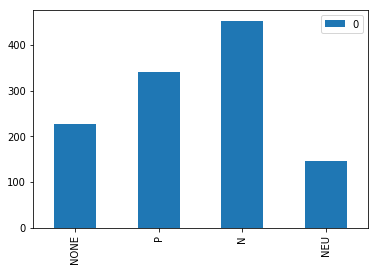

In [11]:
polarity_counts = Counter(df.polarity.values)
plotdf = pd.DataFrame.from_dict(polarity_counts, orient='index')
plotdf.plot(kind='bar')

## Classifier

### Turn tweets into features

In [71]:
all_words = nltk.FreqDist([word for tweet in df.content for word in nltk.word_tokenize(tweet)])
word_features = list(all_words)[:2000] # [_document-classify-all-words]

def document_features(document): # [_document-classify-extractor]
    document_words = set(nltk.word_tokenize(document)) # [_document-classify-set]
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    print(Text(document).language)
    return features

featuresets = [(document_features(d), c) for (d,c) in zip(df.content, df.polarity)]
n = 5
kf = KFold(n_splits=n, shuffle=True)
total = 0
for train, test in kf.split(featuresets):
    classifier = nltk.NaiveBayesClassifier.train(np.array(featuresets)[train])
    total += nltk.classify.accuracy(classifier, (np.array(featuresets)[test]))
print("Accuracy:", total / n)

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: English     code: en       confidence:  95.0 read bytes:   323
name: Spanish     code: es       confidence:  98.0 read bytes:   398
name: Spanish     code: es       confidence:  98.0 read bytes:   834
name: Portuguese  code: pt       confidence:  96.0 read bytes:   256
name: Spanish     code: es       confidence:  98.0 read bytes:   475
name: Spanish     code: es       confidence:  98.0 read bytes:   611
name: Spanish     code: es       confidence:  98.0 read bytes:   332
name: Spanish     code: es       confidence:  98.0 read bytes:   421
name: Spanish     code: es       confidence:  98.0 read bytes:   290
name: Spanish     code: es       confidence:  98.0 read bytes:   292
name: Spanish     code: es       confidence:  98.0 read bytes:   256
name: Spanish     code: es       confidence:  98.0 read bytes:   487
name: Spanish     code: es       confidence:  98.0 read bytes:   341
name: Spanish     code: es       confidence:  98.0 read bytes:   688
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: Spanish     code: es       confidence:  98.0 read bytes:   333
name: Spanish     code: es       confidence:  98.0 read bytes:   768
name: Spanish     code: es       confidence:  98.0 read bytes:   848
name: Spanish     code: es       confidence:  98.0 read bytes:   894
name: Spanish     code: es       confidence:  98.0 read bytes:   595
name: Spanish     code: es       confidence:  97.0 read bytes:   768
name: Spanish     code: es       confidence:  98.0 read bytes:   472
name: Spanish     code: es       confidence:  98.0 read bytes:   468
name: Spanish     code: es       confidence:  98.0 read bytes:   934
name: Spanish     code: es       confidence:  96.0 read bytes:   896
name: Spanish     code: es       confidence:  98.0 read bytes:   433
name: Italian     code: it       confidence:  95.0 read bytes:   269
name: Spanish     code: es       confidence:  98.0 read bytes:   506
name: Spanish     code: es       confidence:  98.0 read bytes:   844
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: Spanish     code: es       confidence:  98.0 read bytes:   687
name: Spanish     code: es       confidence:  96.0 read bytes:  1365
name: Portuguese  code: pt       confidence:  98.0 read bytes:   472
name: Spanish     code: es       confidence:  98.0 read bytes:   723
name: Spanish     code: es       confidence:  98.0 read bytes:   478
name: Spanish     code: es       confidence:  98.0 read bytes:   303
name: Spanish     code: es       confidence:  98.0 read bytes:   577
name: Spanish     code: es       confidence:  98.0 read bytes:   265
name: Indonesian  code: id       confidence:  97.0 read bytes:   224
name: Spanish     code: es       confidence:  98.0 read bytes:   504
name: Spanish     code: es       confidence:  98.0 read bytes:   393
name: Spanish     code: es       confidence:  98.0 read bytes:   721
name: Spanish     code: es       confidence:  97.0 read bytes:   284
name: English     code: en       confidence:  94.0 read bytes:   227
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: Spanish     code: es       confidence:  97.0 read bytes:   483
name: Swahili     code: sw       confidence:  96.0 read bytes:   327
name: English     code: en       confidence:  97.0 read bytes:   351
name: English     code: en       confidence:  98.0 read bytes:   421
name: Spanish     code: es       confidence:  92.0 read bytes:  1339
name: Spanish     code: es       confidence:  98.0 read bytes:   906
name: Spanish     code: es       confidence:  98.0 read bytes:   826
name: Spanish     code: es       confidence:  98.0 read bytes:   798
name: Spanish     code: es       confidence:  98.0 read bytes:   537
name: Spanish     code: es       confidence:  97.0 read bytes:   636
name: Spanish     code: es       confidence:  98.0 read bytes:   549
name: English     code: en       confidence:  94.0 read bytes:    60
name: Spanish     code: es       confidence:  98.0 read bytes:   678
name: Spanish     code: es       confidence:  98.0 read bytes:  1024
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: English     code: en       confidence:  95.0 read bytes:   325
name: Spanish     code: es       confidence:  98.0 read bytes:   445
name: Portuguese  code: pt       confidence:  95.0 read bytes:   358
name: Spanish     code: es       confidence:  97.0 read bytes:   934
name: Spanish     code: es       confidence:  96.0 read bytes:   785
name: Portuguese  code: pt       confidence:  96.0 read bytes:   804
name: Spanish     code: es       confidence:  97.0 read bytes:   232
name: Spanish     code: es       confidence:  98.0 read bytes:   872
name: Spanish     code: es       confidence:  98.0 read bytes:   608
name: Spanish     code: es       confidence:  97.0 read bytes:  1166
name: Spanish     code: es       confidence:  98.0 read bytes:   946
name: Spanish     code: es       confidence:  95.0 read bytes:   623
name: Spanish     code: es       confidence:  96.0 read bytes:   576
name: Spanish     code: es       confidence:  98.0 read bytes:  1175
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: Spanish     code: es       confidence:  96.0 read bytes:  1327
name: Spanish     code: es       confidence:  97.0 read bytes:  1266
name: Spanish     code: es       confidence:  96.0 read bytes:  1271
name: English     code: en       confidence:  95.0 read bytes:   323
name: Spanish     code: es       confidence:  96.0 read bytes:   363
name: Spanish     code: es       confidence:  97.0 read bytes:   351
name: Spanish     code: es       confidence:  96.0 read bytes:   512
name: Spanish     code: es       confidence:  98.0 read bytes:   379
name: English     code: en       confidence:  94.0 read bytes:   361
name: English     code: en       confidence:  93.0 read bytes:    68
name: Spanish     code: es       confidence:  97.0 read bytes:   553
name: Spanish     code: es       confidence:  97.0 read bytes:   263
name: Spanish     code: es       confidence:  97.0 read bytes:  1158
name: Spanish     code: es       confidence:  96.0 read bytes:  1597
name: English     code: en       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


name: Spanish     code: es       confidence:  98.0 read bytes:   974
name: Spanish     code: es       confidence:  98.0 read bytes:   690
name: Spanish     code: es       confidence:  74.0 read bytes:   747
name: Spanish     code: es       confidence:  98.0 read bytes:   678
name: Spanish     code: es       confidence:  99.0 read bytes:   516
name: Spanish     code: es       confidence:  98.0 read bytes:   500
name: Spanish     code: es       confidence:  98.0 read bytes:   445
name: Spanish     code: es       confidence:  98.0 read bytes:   345
name: Spanish     code: es       confidence:  98.0 read bytes:   493
name: Spanish     code: es       confidence:  98.0 read bytes:   812
name: Spanish     code: es       confidence:  98.0 read bytes:   484
name: Spanish     code: es       confidence:  98.0 read bytes:   632
name: Spanish     code: es       confidence:  98.0 read bytes:   590
name: Spanish     code: es       confidence:  98.0 read bytes:   614
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

name: Spanish     code: es       confidence:  95.0 read bytes:   870
name: Irish       code: ga       confidence:  95.0 read bytes:   279
name: Spanish     code: es       confidence:  98.0 read bytes:   610
name: Spanish     code: es       confidence:  96.0 read bytes:   696
name: Spanish     code: es       confidence:  98.0 read bytes:   866
name: Spanish     code: es       confidence:  97.0 read bytes:   893
name: Spanish     code: es       confidence:  98.0 read bytes:   390
name: Spanish     code: es       confidence:  98.0 read bytes:  1005
name: Spanish     code: es       confidence:  98.0 read bytes:   819
name: Spanish     code: es       confidence:  95.0 read bytes:   890
name: Spanish     code: es       confidence:  97.0 read bytes:   426
name: English     code: en       confidence:  98.0 read bytes:   346
name: Spanish     code: es       confidence:  98.0 read bytes:   389
name: English     code: en       confidence:  98.0 read bytes:   348
name: Spanish     code: es       c

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


name: Spanish     code: es       confidence:  94.0 read bytes:   910
name: Spanish     code: es       confidence:  97.0 read bytes:   367
name: Spanish     code: es       confidence:  98.0 read bytes:   429
name: Spanish     code: es       confidence:  98.0 read bytes:   694
name: Spanish     code: es       confidence:  98.0 read bytes:   720
name: Spanish     code: es       confidence:  95.0 read bytes:   930
name: Spanish     code: es       confidence:  98.0 read bytes:   432
name: Spanish     code: es       confidence:  98.0 read bytes:   827
name: Spanish     code: es       confidence:  98.0 read bytes:  1188
name: Spanish     code: es       confidence:  97.0 read bytes:   640
name: English     code: en       confidence:  96.0 read bytes:   433
name: Spanish     code: es       confidence:  98.0 read bytes:   718
name: Spanish     code: es       confidence:  98.0 read bytes:   356
name: Spanish     code: es       confidence:  98.0 read bytes:   668
name: Spanish     code: es       c

KeyboardInterrupt: 

In [13]:
classifier.show_most_informative_features(5)

Most Informative Features
        contains(lindar) = True                P : N      =     13.9 : 1.0
        contains(triste) = True                N : P      =     12.6 : 1.0
         contains(final) = True              NEU : P      =     10.1 : 1.0
          contains(gran) = True                P : N      =      9.4 : 1.0
       contains(cambiar) = True              NEU : P      =      8.5 : 1.0
